In [37]:
%matplotlib inline
from IPython import display
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import astropy.units as u
from examineFlare import examineFlare

In [38]:
prefix = '1to13'
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec1to13/'
log_path = path + 'log/'
plots_path = path + 'plots_filt/'

In [57]:
from scipy import stats
df = pd.read_csv(log_path + prefix + '_flare_out.csv')
df_param = pd.read_csv(log_path + prefix + '_param_out.csv')
df['pvalue'] = 1 - stats.chi2(1).cdf(df['g_chisq'] - df['f_chisq'])
mask = (df['skew'] > 0.5) & (df['f_chisq'] > 0) & (df['f_fwhm_win'] < 0.1) &(df['g_fwhm_win'] < 0.1) &\
       (df['ed'] > 0) &(df['tpeak'] > df['t0']) & (df['tpeak'] < df['t1']) & (df['cover'] > 0.9) &\
       (df['pvalue'] < 0.05) & (df['f_chisq'] < 100)
print(len(df), len(np.unique(df['file'])), len(df[mask]), len(np.unique(df[mask]['file'])))

df_flare = df[mask]
flare_files = np.unique(df_flare['file'])

397424 52102 2315 1640


In [40]:
def disp_fl():
    lc_file = 'lc.png'
    flare_file = 'flares.png'
    display.display(filename)
    display.display(display.Image(lc_file))
    display.display(display.Image(flare_file))

In [41]:
# Compare with Tu 2019
TIC1 = 121011020 # Should be a detection at t=1431
TIC2 = 231631019 # Should be a detection at 1343, but very weak and didnt follow psf
TIC3 = 43472154 # 200 superflares / yr

In [42]:
len(df_param)

247823

In [43]:
fields = ['f_chisq', 'g_chisq', 'pvalue', 'f_fwhm_win', 'g_fwhm_win', 'cover', 't0']

In [44]:
df_flare[df_flare['TIC'] == TIC1][fields]

,f_chisq,g_chisq,pvalue,f_fwhm_win,g_fwhm_win,cover,t0
290042,14.772910,70.270672,9.359180e-14,0.013358,0.010491,0.982684,1424.934892
290045,43.382334,226.311986,0.000000e+00,0.011240,0.011141,1.000000,1431.368260


In [45]:
df[df['TIC'] == TIC1][fields]

,f_chisq,g_chisq,pvalue,f_fwhm_win,g_fwhm_win,cover,t0
290042,14.772910,70.270672,9.359180e-14,0.013358,0.010491,0.982684,1424.934892
290043,2.075786,1.990843,1.000000e+00,0.050248,0.045583,1.000000,1425.450176
290044,1.403850,1.520064,7.331782e-01,0.074387,0.040560,1.000000,1428.312699
290045,43.382334,226.311986,0.000000e+00,0.011240,0.011141,1.000000,1431.368260


In [46]:
df_flare[df_flare['TIC'] == TIC2][fields]

,f_chisq,g_chisq,pvalue,f_fwhm_win,g_fwhm_win,cover,t0


In [47]:
df[df['TIC'] == TIC2][fields]

,f_chisq,g_chisq,pvalue,f_fwhm_win,g_fwhm_win,cover,t0
176480,1.846097,4.389212,0.110776,0.045776,0.025435,0.958904,1331.276811
176481,4.113898,7.459052,0.067403,0.030750,0.017749,0.975000,1343.552981
176482,5.505519,5.706004,0.654329,0.476806,0.281294,0.718750,1348.468120
176483,4.868632,4.931051,0.802712,1.683301,0.630892,0.205479,1348.665336
176484,6.980379,7.550571,0.450182,0.588939,0.400034,0.348837,1348.808387
176485,4.509947,4.551792,0.837916,2.153807,0.572226,0.253695,1348.615337
176486,-1.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,1348.923661
176487,5.079499,5.091933,0.911216,2.109333,0.541767,0.376344,1348.911161
176488,6.828655,7.177757,0.554622,0.813891,0.303427,0.314815,1349.097267


In [48]:
df_flare[df_flare['TIC'] == TIC3][fields]

,f_chisq,g_chisq,pvalue,f_fwhm_win,g_fwhm_win,cover,t0
132092,5.431806,13.495434,0.004516,0.014759,0.012858,0.996503,1454.027017


In [49]:
df[df['TIC'] == TIC3][fields]

,f_chisq,g_chisq,pvalue,f_fwhm_win,g_fwhm_win,cover,t0
132071,0.661158,0.859043,0.656434,0.078895,0.051337,0.969697,1438.594828
132072,4.211895,2.632326,1.000000,0.026445,0.017024,0.990909,1438.679553
132073,4.345603,3.795451,1.000000,0.025843,0.020678,0.996865,1438.885115
132074,0.801086,0.777380,1.000000,0.053734,0.036790,0.984848,1439.380964
132075,1.185075,1.472540,0.591850,0.034801,0.029485,1.000000,1441.735192
132076,2.441930,2.022477,1.000000,0.102944,0.076612,1.000000,1442.156035
132077,0.809608,2.171568,0.243198,0.020477,0.013446,1.000000,1443.076888
132078,2.395567,1.754716,1.000000,0.038589,0.032475,0.974747,1444.289412
132079,16.918011,1.409189,1.000000,0.000003,0.022796,0.690909,1444.414414
132080,0.823508,0.860017,0.848467,0.038185,0.034583,1.000000,1444.597750


In [50]:
# Measure flare energies from GAIA data
tic_gaia_table = pd.read_csv('ticGAIA1to13.csv')
df_flare_g = pd.merge(tic_gaia_table, df_flare, on='TIC', how='inner')
df_flare_g = df_flare_g.dropna(subset=['lum'])
ed = (df_flare_g['ed'].values*u.day).to(u.s)
energy = (ed*df_flare_g['lum']*u.erg/u.s).value
df_flare_g['energy'] = energy
print(len(df_flare), len(df_flare_g))

2315 1783


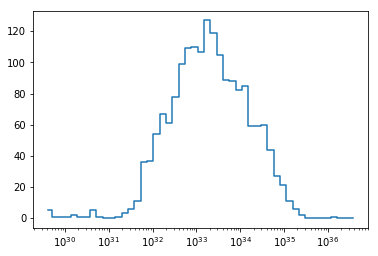

In [51]:
en = df_flare_g['energy']
logbins = np.logspace(np.log10(np.min(en)), np.log10(np.max(en)))
hist, bins = np.histogram(en, bins=logbins)
bins = 0.5*(bins[1:] + bins [:-1])
plt.plot(bins, hist, linestyle='steps-mid')
plt.xscale('log')

In [52]:
np.max(en)

4.2612741888513524e+36

In [53]:
# Sort rows by energy (top = highest)
energy_ind = np.argsort(df_flare_g['energy'].values)[::-1]
df = df_flare_g.iloc[energy_ind]

1483.6317043457193


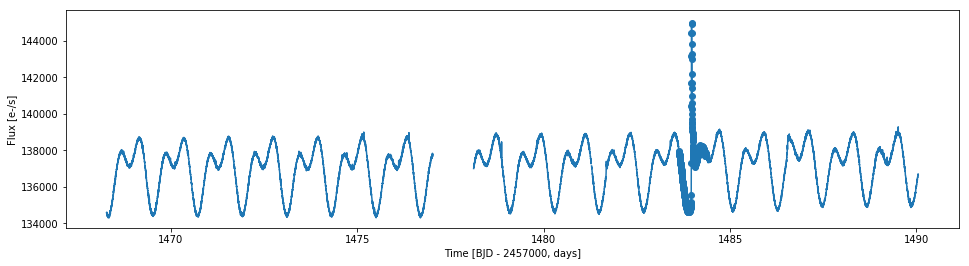

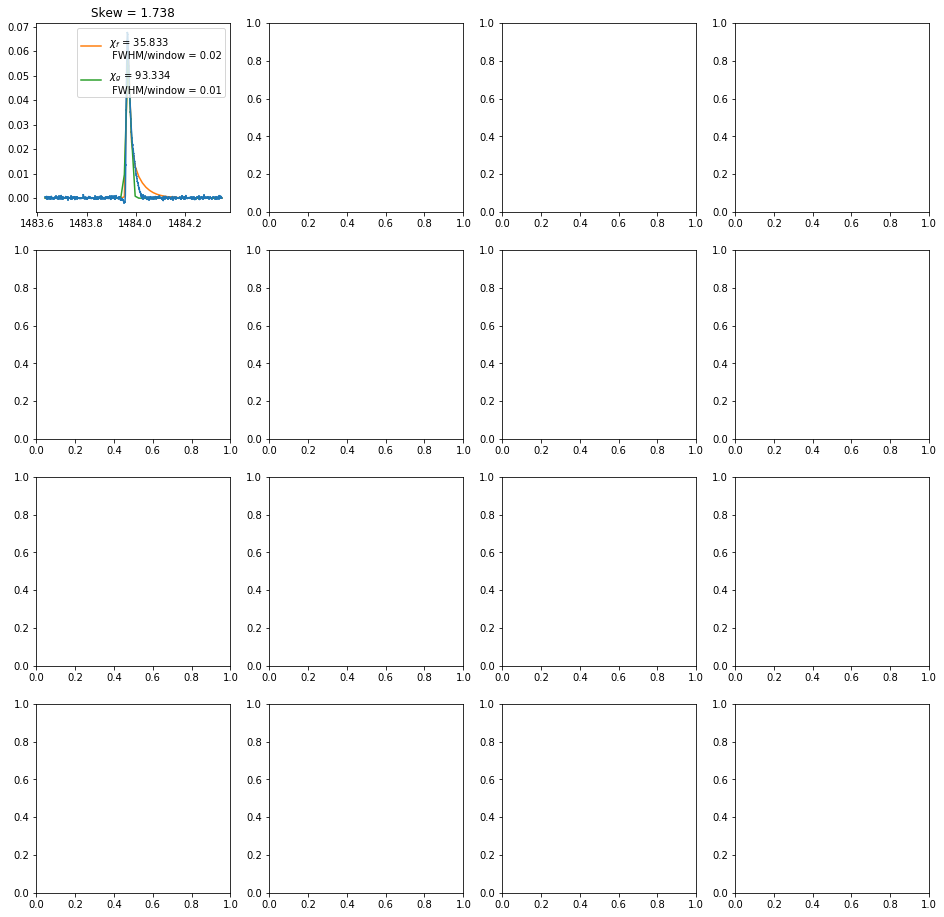

In [54]:
ind = 2
filename = df.iloc[ind]['file']
print(df.iloc[ind]['t0'])
examineFlare(filename, t0_list=[df.iloc[ind]['t0']])

In [55]:
df_flare[df_flare['file'] == filename][fields]

,f_chisq,g_chisq,pvalue,f_fwhm_win,g_fwhm_win,cover,t0
53860,35.832651,93.334146,3.375078e-14,0.01684,0.012622,1.001938,1483.631704
